<a href="https://colab.research.google.com/github/assafrbi/mini-project-Digital-Humanities/blob/main/dh_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling of Israeli Movies Synopses - Digital Humanities Mini Project

In this project, we explore the hidden structures of ±1000 IMDB movies, originated in Israel, based on their synopses content.
Summary of the machine learning flow:

* **Problem statement:**	Unsupervised classification on given movie synopses by NLP
* **Data preprocessing:**	Tokenization and stemming
* **Model training:**	Latent Dirichlet Allocation (LDA) for topic modeling
* **Evaluation:**	main question: Have movie topics, in the Israeli Movie industry, changed over the years?
* **Result:**	Visualiztion of words in each topic, their intertopic distance and the classification of topic to years

The input dataset contains synopses for [IMDB's Feature Films originated in Israel](https://www.imdb.com/search/title/?title_type=feature&countries=il&start=1&ref_=adv_nxt). Each synopsis, or document, is encoded by vector denoting the weight of tokens, which can represent a word or word collection formulated by Bag-of-words model and N-gram model. The weight of each token is determined by the frequency of the term. In the feature engineering stage, each document can be vectorized by the distribution of words.
We adopt Latent Dirichlet Allocation (LDA) to include semantic relation and extract hidden topics.



## Part 1: Load Data from IMDb

**Attention: This stage should run only once to collect data!!! Once the dataset is ready, we can use it by uploading it in the relevant place**

In [1]:
!pip install cinemagoer
!pip install wikipedia

import re
import pandas as pd
from pydoc import synopsis
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import concurrent.futures
import numpy as np
from imdb import Cinemagoer
import time
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=5490aa744e56b4724de2cd04e392afd15f0831856fb7f7a7699c6b31c84a5de4
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [2]:
ia = Cinemagoer()
data = []

In [3]:
def getMovieId(image):
  try:
    return image.get('data-tconst')[2:]
  except:
    return 'NA'

def getMovieTitle(header):
  try:
    return header[0].find("a").getText()
  except:
    return 'NA'

def getReleaseYear(header):
  try:
    return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText().strip()[-5:-1]
  except:
    return 'NA'

def getGenre(muted_text):
  try:
    return muted_text.find("span",  {"class":  "genre"}).getText().strip()
  except:
    return 'NA'
        
def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

def getSynopsisFromImdb(id):
  movie = ia.get_movie(id)
  try:
    plot = movie.get('plot')[0]
    indx = plot.find('::')
    if indx != -1:
      return plot[:indx]
  except:
    plot = np.nan
  return plot

In [ ]:
def main(imdb_url):
  response = requests.get(imdb_url)
  soup = BeautifulSoup(response.text, 'html.parser')

  # Movie Name
  movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
  i = 0
  for movie in movies_list:
    header = movie.find_all("h3", {"class":  "lister-item-header"})
    muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
    imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
    image = imageDiv.find("img", "loadlate")
        
    # Movie Title
    movie_title = getMovieTitle(header)

    # Movie id
    id = getMovieId(image)
        
    # Movie release year
    year = getReleaseYear(header)

    # Movie Synopsys
    synopsis = getSynopsisFromImdb(id)

    # Genre
    genre = getGenre(muted_text)

    data.append({'IMDb_id': id, 'Title': movie_title, 'Year': year, 'Genre': genre, 'Synopsis': synopsis})

In [ ]:
# An array to store all the URL that are being queried
imageArr = []

# Maximum number of pages one wants to iterate over
MAX_PAGE =51

# Loop to generate all the URLS.
for i in range(1, 1500, 50):
  imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&countries=il&start={i}&ref_=adv_nxt'
  imageArr.append(imdb_url)

In [ ]:
# Maximum number of threads that will be spawned
MAX_THREADS = 2

def download_stories(story_urls):
  threads = min(MAX_THREADS, len(story_urls))
  with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    time.sleep(0.3)
    executor.map(main, story_urls)

In [ ]:
# Call the download function with the array of URLS called imageArr
download_stories(imageArr)

In [ ]:
df = pd.DataFrame(data)
# save data
df.to_csv('israel_originated_movies_imdb.csv')

### Load Synopses from Wikipedia

In [ ]:
import wikipedia

wiki_title = []
wiki_plot = []
wiki_summary = []

In [ ]:
def find_title_on_wikipedia(title, year):
    search_results = wikipedia.search(title, results=20)
    search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    
    if len(search_results_exact) != 0: # if the title is part of at least one result

        # if film exists in title but not together with series or score (an example was Resident Evil 2002)
        search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]

        # Go on by additionaly searching for the year in the title
        if len(search_results_film) == 0: # if there is no results with 'film' in the title
            search_results_year = [s for s in search_results_exact if str(year) in s]
            if len(search_results_year) == 0: # if there is no results with year in the title
                search_results_final = search_results_exact
            else:
                search_results_final = search_results_year
        else:
            search_results_year = [s for s in search_results_film if str(year) in s]
            if len(search_results_year) == 0:
                search_results_final = search_results_film
            else:
                search_results_final = search_results_year  

        # for the possible remains of the search results take the exact match or the first result
        for s in search_results_final:
            if s == title:
                title = s
            else:
                title = search_results_final[0]
    
    else: # take the first result
        title = search_results[0]

    return title

def add_wikipedia(data):
  for i in range (len(data)):
    imdb_title = data['English Title'][i]
    year = data['Year'][i]
    title, page, summary = np.nan, np.nan, np.nan

    title = find_title_on_wikipedia(imdb_title, year)
    
    if title != None or title != np.nan:
      page = wikipedia.WikipediaPage(title = title)

      if page != None or page != np.nan:
        summary = page.summary

    wiki_title.append(title)
    wiki_summary.append(summary)


In [ ]:
data = pd.read_csv('israel_originated_movies_imdb_cleared.csv')
add_wikipedia(data)
data['Wiki Title'] = wiki_title
data['Wiki Summary'] = wiki_summary

In [ ]:
data.to_csv('israel_originated_movies_imdb_with_wiki.csv')
data

## Part 2: Text Preprocessing

In [4]:
!pip install pyLDAvis
!pip install swifter

from pydoc import synopsis
from dateutil.parser import parse
import concurrent.futures
import json
import re
import glob
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
nltk.download('all')
import pyLDAvis
import pyLDAvis.gensim_models
import collections
from operator import itemgetter
from scipy import stats
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import swifter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4a6dd35a086e9973abfaaa5bfe29ceca91c27af7861e8ead1dd65e411b095395
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 825 kB 5.5 MB/s 
     |████████████████████████████████| 281 kB 68.5 MB/s 
     |████████████████████████████████| 140 kB 25.6 MB/s 
  Created wheel for swifter: filename=swifter-1.3.2-py3-none-any.whl size=16199 sha256=446d703399973af19d3e67

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

clean year representation. Records with null values removed as well

In [5]:
cleared_data = pd.read_csv('israel_originated_movies_imdb.csv').dropna()
cleared_data = cleared_data[cleared_data.Year != '(III']
cleared_data = cleared_data[cleared_data.Year != '(LX']
cleared_data = cleared_data[cleared_data.Year != '(II']
cleared_data = cleared_data[cleared_data.Year != '(I']
cleared_data = cleared_data[cleared_data.Year != '(V']
cleared_data = cleared_data[cleared_data.Year != '(VII']
cleared_data = cleared_data[cleared_data.Year != '(VI']
cleared_data = cleared_data[cleared_data.Year != '(X']
cleared_data = cleared_data[cleared_data.Year != 'XXXI']

cleared_data.to_csv('ready_for_topic_modeling.csv', index=False)

cleared_data

FileNotFoundError: ignored

 Tokenize and Clean quotes, new line, verbs etc.

In [6]:
def remove_new_line_characters(text):
  return re.sub('\s+', ' ', text)

def remove_quotes(text):
  text = re.sub("\'", "", text)
  text = re.sub('\"', '', text)
  return text

def lowercase(text):
  return text.lower()    

def remove_single_char_words(text):
  return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
  final_text = ''
  allowedWordTypes = ["J","R","N"]
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  for w in tagged:
    if w[1][0] in allowedWordTypes:
      final_text += f' {w[0]}'
  return final_text

def text_preprocess(text):
  text = remove_new_line_characters(text)
  text = remove_quotes(text)
  text = lowercase(text)
  text = remove_single_char_words(text)
  text = remove_verbs(text)
  return text

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
ready_data = pd.read_csv('ready_for_topic_modeling.csv')

ready_data.loc[ready_data['Synopsis']!='']
source = 'Synopsis'
data = ready_data.copy()

print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')

data[source] = data[source].apply(lambda x: text_preprocess(x))

data = data[source].to_list()
data_words = list(sent_to_words(data))

---Doing pre-processing for Synopsis..
Initial pre-processing..


Build the Bigram, Trigram Models and Lemmatize

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['israeli','israelis', 'film', 'films', 'story', 'movie', 'movies', 'year'])
print ('We use {} stop-words from nltk library.'.format(str(len(stopwords))))
print ('First ten stop-words are {}'.format(stopwords[:10]))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]
  
def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(" ".join(sent)) 
  return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
  str1 = " " 
  return str1.join(the_list)

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

We use 187 stop-words from nltk library.
First ten stop-words are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [9]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ready_data[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops, bigram_mod)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ready_data[f'{source}_lemmatized'] = ready_data[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ready_data = ready_data.drop(columns=[f'{source}_words_bigrams'])
ready_data[f'{source}_preprocessed'] = ready_data[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

ready_data

Removing stopwords..
Creating bigrams..
Lemmatizing words..


Pandas Apply:   0%|          | 0/1052 [00:00<?, ?it/s]

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed
0,0,3605418,Knock Knock,2015,"Drama, Thriller",A devoted father helps two stranded young wome...,"[father, strand, young, woman, door, kind, ges...",father strand young woman door kind gesture da...
1,1,95182,The Frog Prince,1986,"Drama, Family, Fantasy",Children's musical based on Grimm's fairy tale...,"[children, musical, grimms, fairy, tale, frog,...",children musical grimms fairy tale frog king y...
2,2,9100054,The Lost Daughter,2021,Drama,A woman's beach vacation takes a dark turn whe...,"[vacation, dark, turn, trouble, past]",vacation dark turn trouble past
3,3,6896536,Foxtrot,2017,Drama,A troubled family must face the facts when som...,"[troubled, family, fact, terribly, wrong, son,...",troubled family fact terribly wrong son milita...
4,4,90859,Cobra,1986,"Action, Crime, Thriller",A tough-on-crime street cop must protect the o...,"[tough, cop, witness, murderous, cult, far, re...",tough cop witness murderous cult far reach plan
...,...,...,...,...,...,...,...,...
1047,1461,2388797,Up the Wrong Tree,2013,Drama,"This is the story of Nits, a restless bum and ...","[nit, restless, hopeless, cynic, journey, obse...",nit restless hopeless cynic journey obsessive ...
1048,1463,138884,Transit,1980,Drama,A Jewish refugee in Israel,[],
1049,1464,21249770,Marionette,2019,Drama,'Marionette' is a human comedy-drama focused o...,"[marionette, human, comedy, drama, navon, mili...",marionette human comedy drama navon military r...
1050,1466,1826755,Who Are You to Me?,2010,Drama,"An encounter between two people, both outsider...","[encounter, people, outsider, normal, society,...",encounter people outsider normal society painf...


#### Most common words


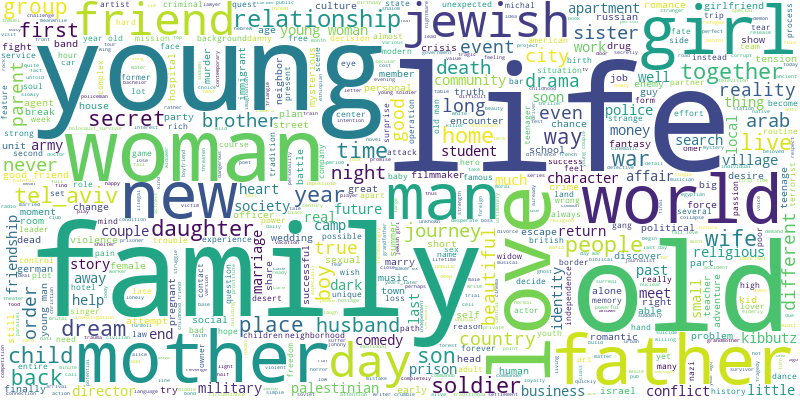

In [10]:
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    contour_width=3,
    contour_color='steelblue',
    width=800,
    height=400)
# Join the different processed titles together.
long_string = ','.join(ready_data[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Part 3: Topic Modeling - Latent Dirichlet Allocation

Build The Topic Model

In [11]:
def build_LDA_model(ready_data, source, num_topics):
  # Create the Dictionary and Corpus needed for Topic Modeling
  # Create Dictionary
  id2word = corpora.Dictionary(ready_data[f'{source}_lemmatized'].tolist())
  # Create Corpus
  texts = ready_data[f'{source}_lemmatized'].tolist()
  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]
  del texts
  
  # Build LDA model
  lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
  return lda_model, corpus, id2word

def allocate_topics(i, lda_model):
  return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
  return max(x, key=itemgetter(1))[0]

In [12]:
num_topics = 10
lda_model, corpus, id2word = build_LDA_model(ready_data, source=source, num_topics=num_topics)
lda_model.save('lda_model')

## Part 4: Evaluation

In this section we will try to answer the question
> **Have movie topics, in the Israeli Movie industry, changed over the years?**

In [13]:
lda_model.print_topics()

[(0,
  '0.011*"life" + 0.010*"mother" + 0.010*"young" + 0.009*"day" + 0.008*"together" + 0.008*"woman" + 0.008*"father" + 0.008*"time" + 0.007*"group" + 0.007*"reality"'),
 (1,
  '0.010*"people" + 0.009*"never" + 0.008*"family" + 0.007*"world" + 0.007*"life" + 0.007*"girl" + 0.006*"live" + 0.006*"way" + 0.006*"different" + 0.006*"young"'),
 (2,
  '0.013*"old" + 0.011*"family" + 0.008*"life" + 0.008*"love" + 0.008*"father" + 0.007*"relationship" + 0.007*"search" + 0.006*"last" + 0.006*"woman" + 0.006*"process"'),
 (3,
  '0.018*"young" + 0.017*"family" + 0.010*"life" + 0.008*"friend" + 0.007*"war" + 0.006*"event" + 0.006*"old" + 0.006*"day" + 0.006*"couple" + 0.006*"dream"'),
 (4,
  '0.017*"love" + 0.015*"woman" + 0.013*"life" + 0.010*"young" + 0.009*"friend" + 0.008*"new" + 0.008*"girl" + 0.007*"wife" + 0.006*"husband" + 0.006*"old"'),
 (5,
  '0.016*"life" + 0.012*"man" + 0.010*"woman" + 0.010*"love" + 0.010*"soldier" + 0.009*"young" + 0.009*"relationship" + 0.007*"old" + 0.007*"girl" +

Assign Dominant Topic to each record

In [14]:
ready_data['i'] = [i for i in range(len(ready_data))]
ready_data[f'{source}_topic'] = ready_data['i'].swifter.apply(lambda x: allocate_topics(x, lda_model))
ready_data[f'{source}_topic'] = ready_data[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

del ready_data['i']
ready_data = ready_data.sort_values(by=[f'{source}_topic'])
ready_data

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

,Unnamed: 0,IMDb_id,Title,Year,Genre,Synopsis,Synopsis_lemmatized,Synopsis_preprocessed,Synopsis_topic
1051,1468,5566984,Hoze Lech Brach,2008,Drama,Urban Odyssey one night in Tel Aviv.,"[urban, night, tel_aviv]",urban night tel_aviv,0
259,264,67682,Robinson und seine wilden Sklavinnen,1972,"Adventure, Comedy",Meet Poor old Mr Robinson who is so bored at h...,"[meet, poor, old, bore, home, terrible, annoyi...",meet poor old bore home terrible annoying wife...,0
263,270,12716170,Laila in Haifa,2020,"Comedy, Drama",Laila In Haifa is set over one fateful night i...,"[fateful, night, club, port, town, story, woma...",fateful night club port town story woman snaps...,0
766,871,8040482,Alaska,2018,Drama,Lolek suffers from alzheimer's disease. He is ...,"[lolek, suffer, alzheimer, disease, long, term...",lolek suffer alzheimer disease long term next ...,0
763,864,133600,On the Fringe,1987,Drama,Set against the scenic backdrop of a vibrant N...,"[scenic, backdrop, fall, homecoming, healing, ...",scenic backdrop fall homecoming healing unfold...,0
...,...,...,...,...,...,...,...,...,...
829,986,7217158,Different Sky,2006,"Drama, Romance","Love story of a young couple, Amad and Isabell...","[young, couple, isabella, amad, palestinian, n...",young couple isabella amad palestinian nablus ...,9
403,416,1305027,Podarok Stalinu,2008,Drama,A Jewish child deported to Kazakhstan is saved...,"[jewish, child, old, man, name, sabyr, humble,...",jewish child old man name sabyr humble child s...,9
201,203,2841572,A Borrowed Identity,2014,Drama,A Palestinian-Israeli boy named Eyad is sent t...,"[palestinian, boy, eyad, prestigious, school, ...",palestinian boy eyad prestigious school issue ...,9
974,1245,1311654,Halakeh,2008,Drama,This is the story of a journey made by a young...,"[journey, young, religious, family, old, son, ...",journey young religious family old son yoni ba...,9


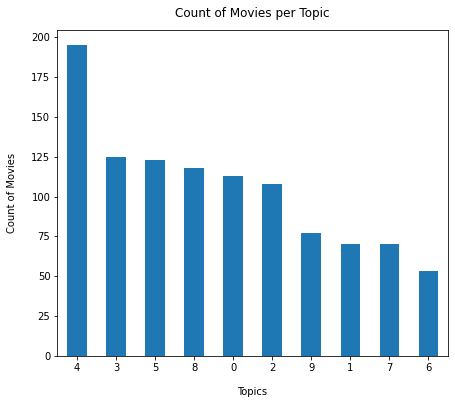

In [15]:
ready_data[f'{source}_topic'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0);
plt.xlabel("Topics", labelpad=14)
plt.ylabel("Count of Movies", labelpad=14)
plt.title("Count of Movies per Topic", y=1.02);

**The average years of the movies, classified according to the Topics**

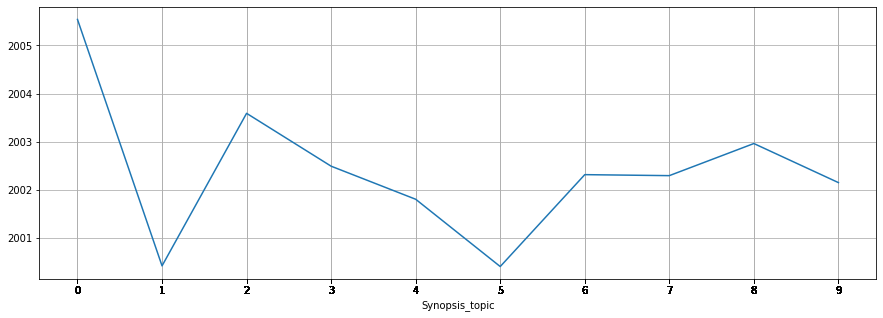

In [16]:
movie_avg = ready_data.copy()
movie_avg = movie_avg.drop(columns=['IMDb_id', 'Title', 'Synopsis', 'Synopsis_lemmatized', 'Synopsis_preprocessed', 'Genre', 'Unnamed: 0'])
movie_avg.groupby(f'{source}_topic')['Year'].mean().plot(x=f'{source}_topic', xticks=movie_avg[f'{source}_topic'] ,figsize=(15,5), grid=True)

### Visualize Topics


Word Clouds of Top N Keywords in Each Topic

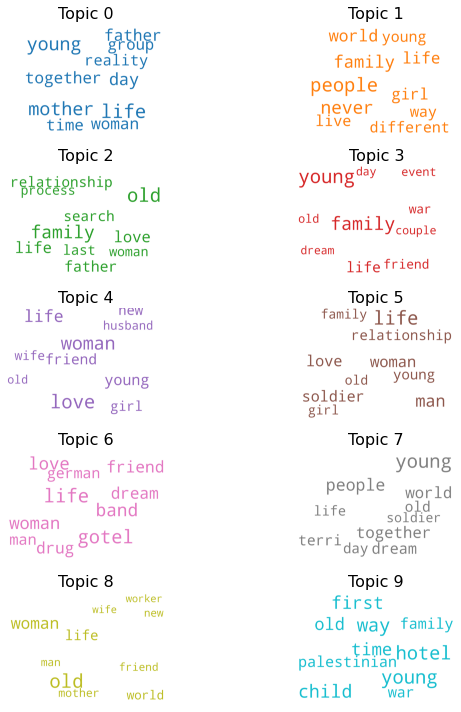

In [17]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.098512 -0.041791       1        1  17.365204
3     -0.025050 -0.073784       2        1  12.333421
5      0.011177 -0.090483       3        1  11.866399
8      0.051108 -0.014893       4        1  11.295833
0      0.127886  0.080191       5        1  10.714353
2     -0.003616 -0.015401       6        1  10.236708
7     -0.026422 -0.019279       7        1   7.405069
1     -0.052195  0.028712       8        1   6.714103
9     -0.135641 -0.015949       9        1   6.694094
6     -0.045759  0.162677      10        1   5.374817, topic_info=        Term        Freq       Total Category  logprob  loglift
104   people   60.000000   60.000000  Default  30.0000  30.0000
182     love  121.000000  121.000000  Default  29.0000  29.0000
118      old  153.000000  153.000000  Default  28.0000  28.0000
4168   gotel   13.000000   13.000000  Default  27.0000  27.0000
383    hotel   12.000000   12.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
129    world    5.244907   82.534861  Topic10  -5.2440   0.1675
93      true    4.294827   36.156117  Topic10  -5.4439   0.7930
32    family    4.326975  133.315177  Topic10  -5.4364  -0.5044
18      good    4.156420   48.254349  Topic10  -5.4766   0.4716
338    small    4.065680   31.943137  Topic10  -5.4987   0.8621

[721 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
714       2  0.073898    able
714       3  0.073898    able
714       4  0.073898    able
714       6  0.221694    able
714       7  0.591183    able
...     ...       ...     ...
12        8  0.048068   young
12        9  0.072101   young
12       10  0.036051   young
4255      9  0.645042    zany
4295      2  0.947373  zodiac

[1520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 9, 1, 3, 8, 2, 10, 7])

## Part 5: Conclusions

1. **It clearly seen (due to the fact that the average is very close to each other) that there is a slight change in the essence of Israeli cinema over the years.**
1. **Most of the movies where assosiated to topic 4 which also has the latest average year (2006).**
2. **The least number of movies where assosiated to topic 9 which also has the oldest average year (1998) and seem to be related to Musical Drama Genres.**
4. **There seems to be a great correlation between topics 2-8.**
3. **Wikipedia does not gives as extra information regarding Israeli movies.**